# Exploratory Data Analysis
Yijing Feng, Dongkai Chen

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import nibabel as nib
import matplotlib.pyplot as plt

from glob import glob
from scipy import signal
from scipy.io import wavfile
from collections import Counter

In [2]:
root_dir = '/isi/music/OpenFMRI/forrest_gump/'

# 1. Spectrograms for all 25 stimuli

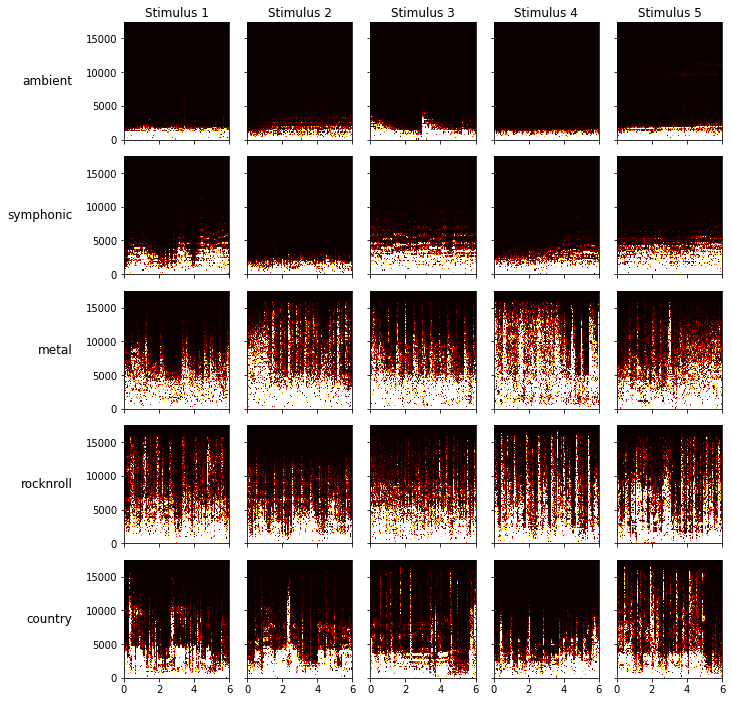

In [17]:
genres = ['ambient', 'symphonic', 'metal', 'rocknroll', 'country']
cols = ['Stimulus {}'.format(i) for i in range(1, 6)]

stimuli_dir = os.path.join(root_dir, 'stimulus', 'task002', 'stimuli')

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))
# plt.setp(axes.flat, xlabel='X-label', ylabel='Y-label')

pad = 5 # in points

for i, ax in enumerate(axes.flat):
    genre = genres[i//5]
    stimuli_fname = os.path.join(stimuli_dir, '{}_{:03d}.wav'.format(genre, i%5))
    sample_rate, samples = wavfile.read(stimuli_fname)
    samples = np.mean(samples, axis=1) # calculate mean for dual channels
    f, t, spectrogram = signal.spectrogram(samples, sample_rate)
    im = ax.pcolormesh(t, f, spectrogram, shading='auto', vmax=100, vmin=0, cmap='hot')
    if i%5:
        ax.axes.yaxis.set_ticklabels([])
    if i//5 != 4:
        ax.axes.xaxis.set_ticklabels([])
    ax.set_xlim(left=0, right=6)
    ax.set_ylim(bottom=0, top=17500)

for ax, col in zip(axes[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(axes[:,0], genres):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')

fig.tight_layout()
fig.subplots_adjust(left=0.15, top=0.95)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.5])
# fig.colorbar(im, cax=cbar_ax)

plt.show()

# 2. Sample slice of fMRI

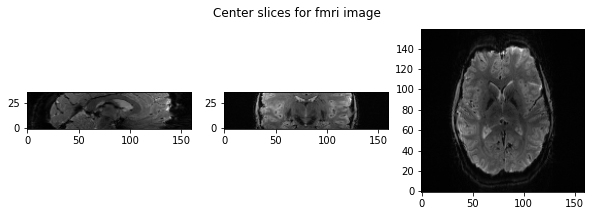

In [35]:
sub_id = 1 # 1 to 20
run_id = 1 # 1 to 8

# Loading fmri data
fmri_fname = os.path.join(root_dir, 'sub{:03d}'.format(sub_id), 'BOLD',
                          'task002_run{:03d}'.format(run_id), 'bold.nii.gz')
fmri_img = nib.load(fmri_fname)
fmri_data = fmri_img.get_fdata()

def show_slices(slices):
    """ Function to display row of image slices """
    fig, axes = plt.subplots(1, len(slices), figsize=(10, 3))
    for i, fmri_slice in enumerate(slices):
        axes[i].imshow(fmri_slice.T, cmap="gray", origin="lower")

# Get the center slices
x,y,z,t = fmri_data.shape
slice0 = fmri_data[x//2, :, :, 0]
slice1 = fmri_data[:, y//2, :, 0]
slice2 = fmri_data[:, :, z//2, 0]

show_slices([slice0, slice1, slice2])

plt.suptitle("Center slices for fmri image")
plt.show()

# 3. Distribution of Volume Intervals

In [58]:
hist_interval = []
log_fname_pattern = log_fname = os.path.join(root_dir, 'sub{:03d}', 'behav', 'task002_run{:03d}', 'behavdata.txt')
for sub_id in range(1,21):
    for run_id in range(1, 9):
        log_fname = log_fname_pattern.format(sub_id, run_id)
        try:
            log_data = pd.read_csv(log_fname)
        except:
            print("Missing Data: {}".format(log_fname, 2))
            continue
        
        volume_index = log_data['run_volume'].to_numpy()
        interval = volume_index[1:] - volume_index[:-1]
        hist_interval.append(interval)

Missing Data: /isi/music/OpenFMRI/forrest_gump/sub020/behav/task002_run005/behavdata.txt
Missing Data: /isi/music/OpenFMRI/forrest_gump/sub020/behav/task002_run006/behavdata.txt
Missing Data: /isi/music/OpenFMRI/forrest_gump/sub020/behav/task002_run007/behavdata.txt
Missing Data: /isi/music/OpenFMRI/forrest_gump/sub020/behav/task002_run008/behavdata.txt


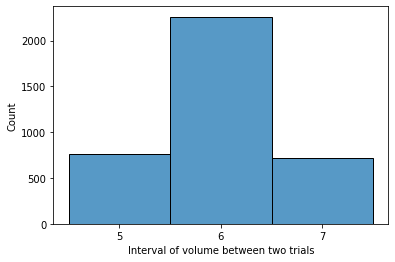

In [59]:
g = sns.histplot(np.concatenate(hist_interval), discrete=True)
g.set_xticks(range(5,8))
g.set_xlabel('Interval of volume between two trials')
plt.show()

# 4. The average central slices when listening to different genres

Within subject analysis

In [42]:
sub_id = 1 # For subject one

genre_cnt = {i:[] for i in genres}
genre_slice = {i:[] for i in genres}
genre_response = {i: Counter() for i in genres}

for run_id in range(1, 9):
    # Load stimulus information/behavior log
    log_fname = os.path.join(root_dir, 'sub{:03d}'.format(sub_id), 
                             'behav', 'task002_run{:03d}'.format(run_id), 'behavdata.txt')
    log_data = pd.read_csv(log_fname)
    
    volume_index = log_data['run_volume'].tolist()
    volume_index = np.array(volume_index + [volume_index[-1]+6])
    genre_label = log_data['genre'].to_numpy()
    
    # Load fmri data
    fmri_fname = os.path.join(root_dir, 'sub{:03d}'.format(sub_id), 'BOLD',
                              'task002_run{:03d}'.format(run_id), 'bold.nii.gz')
    fmri_img = nib.load(fmri_fname)
    fmri_data = fmri_img.get_fdata()
    x,y,z,t = fmri_data.shape
    
    for i, genre in enumerate(genres):
        indices = np.where(genre_label == genre)[0]
        genre_index = np.concatenate([np.arange(volume_index[i], volume_index[i+1]) for i in indices])
        genre_volume = fmri_data[:,:,z//2,genre_index[:12]]
    
        tmp = genre_volume.flatten()
        tmp = tmp[tmp.nonzero()]
        
        genre_cnt[genre].append(tmp)
        genre_response[genre] += Counter(tmp)

        mean_slice = np.mean(genre_volume, axis=2)
        genre_slice[genre] += [[mean_slice, len(genre_index)]]

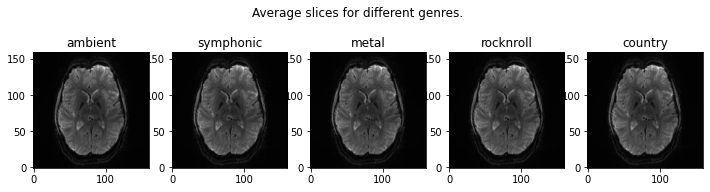

In [22]:
# Show average slices for each genere
fig, axes = plt.subplots(1, len(genres), figsize=(12, 3))

for i, genre in enumerate(genres):
    slices = genre_slice[genre]
    total_cnt = sum([cnt for _, cnt in slices])
    
    sum_slice = np.array([mean_slice * cnt for mean_slice, cnt in slices])
    mean_slice = np.sum(sum_slice, axis=0)/total_cnt
    axes[i].imshow(mean_slice.T, cmap="gray", origin="lower")
    axes[i].set_title(genre)
    
plt.suptitle("Average slices for different genres.")
plt.show()

# 5. The distribution of brain response across different genres

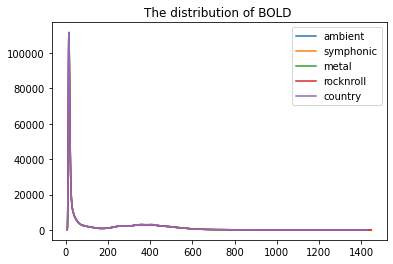

In [39]:
for i, genre in enumerate(genres):
    cnt = np.array(sorted(list(genre_response[genre].items())))
    plt.plot(cnt[:,0][1:], cnt[:,1][1:], label=genre)
plt.title("The distribution of BOLD ")
plt.legend()
plt.show()

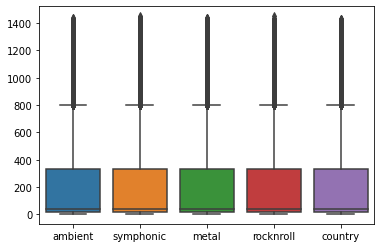

In [48]:
genre_cnt = [np.concatenate(genre_cnt[genre]) for genre in genres]
g = sns.boxplot(data=genre_cnt)
g.set_xticklabels(genres)
plt.show()

In [54]:
print("The mean and variance response for each genre")
for i, cnt in enumerate(genre_cnt):
    print(genres[i], 'Mean: {}'.format(np.round(np.mean(cnt),2)), 'Variance: {}'.format(np.round(np.std(cnt), 2)))

The mean and variance response for each genre
ambient Mean: 165.5 Variance: 195.61
symphonic Mean: 165.66 Variance: 195.8
metal Mean: 165.67 Variance: 195.79
rocknroll Mean: 165.91 Variance: 196.1
country Mean: 165.81 Variance: 196.0
